<a href="https://colab.research.google.com/github/qahtanaa/OnSubGroupFairness/blob/main/Comparisonwother.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%reset -f

In [ ]:
!pip install aif360

In [ ]:
import numpy as np
import pandas as pd
from aif360.metrics import utils
from scipy.sparse import issparse
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
from sklearn.neighbors import NearestNeighbors
from sympy import Symbol
from sympy.solvers import solve
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from aif360.algorithms.preprocessing import *
from aif360.algorithms.preprocessing.optim_preproc_helpers import distortion_functions, opt_tools
from aif360.algorithms.inprocessing import *
from aif360.algorithms.postprocessing import *
import math
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier



---

---


---



DATASET

In [ ]:
def preprocess_dataset(dataset_path, dataset_type, model):
    if dataset_type == 'German':
        df = pd.read_csv(dataset_path)
        df['age'] = df['age'].apply(lambda age: 1 if age >= 25 else 0)
        df['personal_status'] = df['personal_status'].apply(lambda sex: 1 if sex == 'male' else 0)
        print("German dataset:")
        print(df.head())
        sensitive_attributes = ['personal_status','age']
        label = 'credit'
        privileged = [1, 1]
        unprivileged = [0, 0]
        favorable_label = 1
        unfavorable_label = 2
        groups = [
                  {'name': 'Male Adult', 'attributes': {'personal_status': 1, 'age': 1}},
                  {'name': 'Female Adult', 'attributes': {'personal_status': 0, 'age': 1}},
                  {'name': 'Male Young', 'attributes': {'personal_status': 1, 'age': 0}},
                  {'name': 'Female Young', 'attributes': {'personal_status': 0, 'age': 0}}
              ]
        model = model

    elif dataset_type == 'COMPAS':
        df = pd.read_csv(dataset_path)
        selected_columns = ['sex', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count',
                            'juv_other_count', 'priors_count', 'c_charge_degree',
                            'c_charge_desc', 'two_year_recid']
        df = df[selected_columns]
        df = df[(df['race'] == 'Caucasian') | (df['race'] == 'African-American')].reset_index(drop=True)
        print("COMPAS dataset:")
        print(df.head())
        sensitive_attributes = ['race','sex']
        label = 'two_year_recid'
        privileged = ['Caucasian', 'Female']
        unprivileged = ['African-American', 'Male']
        favorable_label = 0
        unfavorable_label = 1
        groups = [
                  {'name': 'Caucasian Female', 'attributes': {'race': 1, 'sex': 1}},
                  {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 1}},
                  {'name': 'Causasian Male', 'attributes': {'race': 1, 'sex': 0}},
                  {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 0}}
              ]
        model = model

    elif dataset_type == 'Adult':
        df = pd.read_csv('/content/raw_adult_dataset.csv', delimiter=';')
        df['income'] = df['income'].str.strip().replace({'>50K.': '>50K', '<=50K.': '<=50K'})
        df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
        df.replace('?', np.nan, inplace=True)
        df = df.drop(columns=['fnlwgt', 'education-num'])
        df = df[(df['race'] == 'White') | (df['race'] == 'Black')].reset_index(drop=True)
        print("Adult dataset:")
        print(df.head())
        sensitive_attributes = ['race','sex']
        label = 'income'
        privileged = ['White', 'Male']
        unprivileged = ['Black', 'Female']
        favorable_label = '>50K'
        unfavorable_label = '<=50K'
        groups = [
                  {'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}},
                  {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}},
                  {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}},
                  {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}}
              ]
        model = model

    return df, sensitive_attributes, label, privileged, unprivileged, favorable_label, unfavorable_label, groups, model

In [ ]:
##################################################################################
df, sensitive_attributes, label, privileged, unprivileged, favorable_label, unfavorable_label, groups, model = preprocess_dataset('/content/raw_adult_dataset.csv', 'Adult', 'Gradient Boosting')
# = '/content/raw_german_dataset.csv', 'German'
# = preprocess_dataset('/content/raw_compas_dataset.csv', 'COMPAS')
# = preprocess_dataset('/content/raw_adult_dataset.csv', 'Adult')

#model == 'Logistic Regression':
#model == 'Random Forest':
#model == 'Gradient Boosting':

Adult dataset:
   age         workclass  education      marital_status         occupation  \
0   39         State-gov  Bachelors       Never-married       Adm-clerical   
1   50  Self-emp-not-inc  Bachelors  Married-civ-spouse    Exec-managerial   
2   38           Private    HS-grad            Divorced  Handlers-cleaners   
3   53           Private       11th  Married-civ-spouse  Handlers-cleaners   
4   28           Private  Bachelors  Married-civ-spouse     Prof-specialty   

    relationship   race     sex  capital_gain  capital_loss  hours_per_week  \
0  Not-in-family  White    Male          2174             0              40   
1        Husband  White    Male             0             0              13   
2  Not-in-family  White    Male             0             0              40   
3        Husband  Black    Male             0             0              40   
4           Wife  Black  Female             0             0              40   

  native_country income  
0  United-State



---

---

---

DATA PREPARATION

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

class DataPreparation():
    """
    ........
    """
    def __init__(self, df, sensitive, label, priv, unpriv, fav, unfav, categorical=[]):
        """
        Construct all necessary attributes for the data preparation.

        df : (pandas DataFrame) containing the data
        sensitive : (list(str)) specifying the column names of all sensitive features
        label : (str) specifying the label column
        priv : (list(dicts)) representation of the privileged groups
        unpriv : (list(dicts)) representation of the unprivileged groups
        fav : (str/int/..) value representing the favorable label
        unfav : (str/int/..) value representing the unfavorable label
        categorical : (list(str)) (optional) specifying column names of categorical features
        """
        self.df = df
        self.sensitive = sensitive
        self.label = label
        self.priv = priv
        self.unpriv = unpriv
        self.fav = fav
        self.unfav = unfav
        self.categorical = categorical

    def detect_missing_values(self):
        """
        Detect rows with missing values and remove them from the DataFrame.
        """
        initial_rows = len(self.df)
        self.df = self.df.dropna()
        removed_rows = initial_rows - len(self.df)

        if removed_rows > 0:
            print(f"Detected {removed_rows} rows with missing values. Removed them.")
        else:
            print("No missing values detected.")  # pass

    def binary_label(self):
        """
        Ensure the decision label and sensitive attributes are encoded as binary, where:
        - Favorable label and privileged groups are encoded as 1.
        - Unfavorable label and unprivileged groups are encoded as 0.
        """
        if len(self.priv) != 2 or len(self.unpriv) != 2:
            raise ValueError("Both 'priv' and 'unpriv' must contain exactly two values.")

        number_label_values = self.df[self.label].nunique()
        if number_label_values == 2:
            print(f"The '{self.label}' column has only two unique values.")
            self.df.loc[:, self.label] = self.df[self.label].replace([self.unfav, self.fav], [0, 1])
        else:
            print(f"The '{self.label}' column does not have exactly two unique values, as it should.")

        # Create mappings for each sensitive attribute
        race_mapping = {self.priv[0]: 1, self.unpriv[0]: 0}
        sex_mapping = {self.priv[1]: 1, self.unpriv[1]: 0}

        # Apply the mappings to the respective columns
        self.df.loc[:, self.sensitive[0]] = self.df[self.sensitive[0]].replace(race_mapping)
        self.df.loc[:, self.sensitive[1]] = self.df[self.sensitive[1]].replace(sex_mapping)

    def find_categorical_attributes(self):
        """
        Identify categorical attributes and encode.
        """
        self.attribute_types = {}

        for column in self.df.columns:
            if column == 'Group':
                continue  # Skip the 'Group' column
            elif column in self.categorical:
                self.attribute_types[column] = 'Categorical'
            elif self.df[column].nunique() == 2:
                self.attribute_types[column] = 'Categorical'
            else:
                num_float = 0
                num_text = 0
                thresh = 0.99
                num_att_in_column = len(self.df[column])

                for value in self.df[column]:
                    try:
                        float(value)
                        num_float += 1
                    except ValueError:
                        num_text += 1

                if num_float / num_att_in_column > thresh:
                    self.attribute_types[column] = 'Numerical'
                else:
                    self.attribute_types[column] = 'Categorical'
        # Boolean
        self.cat_features = []
        for attr in self.attribute_types:
            self.cat_features.append(self.attribute_types[attr] == 'Categorical')

        encoder_dict = dict()
        self.columns_categorical = self.df.columns[self.cat_features]

        for column in self.columns_categorical:
            le = LabelEncoder()
            self.df.loc[:, column] = le.fit_transform(self.df[column].values)
            mapping = dict(zip(le.classes_, range(len(le.classes_))))
            encoder_dict[column] = mapping
        print(encoder_dict, 'encoder dict')
        self.numerical_features = [not feature for feature in self.cat_features]
        self.columns_numerical = self.df.columns[self.numerical_features]

        for column in self.columns_numerical:
            self.df.loc[:, column] = self.df[column].astype(float)

        return self.attribute_types, self.cat_features, self.numerical_features

    def create_group_column(self):
        """
        Create a 'Group' column in the DataFrame based on protected attributes, privileged/unprivileged conditions, and label.
        """
        group_combinations = pd.MultiIndex.from_product([self.df[sensitive].unique() for sensitive in self.sensitive] + [self.df[self.label].unique()], names=self.sensitive + [self.label])
        print(list(enumerate(group_combinations)))
        # Create a mapping between group combinations and their corresponding numbers
        group_mapping = {group: idx for idx, group in enumerate(group_combinations)}
        reverse_group_mapping = {idx: group for group, idx in group_mapping.items()}
        self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)

        return reverse_group_mapping

    def train_test_split(self):
        X = self.df.loc[:, self.df.columns != self.label]
        y = self.df[self.label]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=self.df['Group'])  # , random_state=42

        return self.X_train, self.y_train, self.X_test, self.y_test

    def standardization_numerical(self):
        train_dataset_numerical = self.X_train[self.columns_numerical]
        test_dataset_numerical = self.X_test[self.columns_numerical]

        scaler = StandardScaler().fit(train_dataset_numerical)
        train_dataset_scaled_numerical = scaler.transform(train_dataset_numerical)
        test_dataset_scaled_numerical = scaler.transform(test_dataset_numerical)

        self.X_train.loc[:, self.columns_numerical] = train_dataset_scaled_numerical
        self.X_test.loc[:, self.columns_numerical] = test_dataset_scaled_numerical

        self.X_train = pd.concat([self.X_train, self.y_train], axis=1)
        self.X_test = pd.concat([self.X_test, self.y_test], axis=1)
        return self.X_train, self.X_test

    def prepare(self):
        """
        Perform all preprocessing steps.
        """
        self.detect_missing_values()
        self.binary_label()
        self.find_categorical_attributes()
        self.create_group_column()
        self.train_test_split()
        self.standardization_numerical()
        return self




In [ ]:
##################################################################################
#use the DataPreparation class to preprocess the dataframe
data_prep = DataPreparation(df, sensitive_attributes, label, privileged, unprivileged, favorable_label, unfavorable_label)
data_prep.prepare()
data_prep.df = data_prep.df.reset_index(drop=True)
X_train, X_test = data_prep.X_train, data_prep.X_test
attribute_types = data_prep.attribute_types
cat_features = data_prep.cat_features
numerical_features = data_prep.numerical_features
reverse_group_mapping = data_prep.create_group_column()
#theoretical_num_groups = len(reverse_group_mapping)
X_train = X_train.reset_index(drop=True)

print(X_train.head())

Detected 3316 rows with missing values. Removed them.
The 'income' column has only two unique values.
{'workclass': {'Federal-gov': 0, 'Local-gov': 1, 'Private': 2, 'Self-emp-inc': 3, 'Self-emp-not-inc': 4, 'State-gov': 5, 'Without-pay': 6}, 'education': {'10th': 0, '11th': 1, '12th': 2, '1st-4th': 3, '5th-6th': 4, '7th-8th': 5, '9th': 6, 'Assoc-acdm': 7, 'Assoc-voc': 8, 'Bachelors': 9, 'Doctorate': 10, 'HS-grad': 11, 'Masters': 12, 'Preschool': 13, 'Prof-school': 14, 'Some-college': 15}, 'marital_status': {'Divorced': 0, 'Married-AF-spouse': 1, 'Married-civ-spouse': 2, 'Married-spouse-absent': 3, 'Never-married': 4, 'Separated': 5, 'Widowed': 6}, 'occupation': {'Adm-clerical': 0, 'Armed-Forces': 1, 'Craft-repair': 2, 'Exec-managerial': 3, 'Farming-fishing': 4, 'Handlers-cleaners': 5, 'Machine-op-inspct': 6, 'Other-service': 7, 'Priv-house-serv': 8, 'Prof-specialty': 9, 'Protective-serv': 10, 'Sales': 11, 'Tech-support': 12, 'Transport-moving': 13}, 'relationship': {'Husband': 0, 'Not-

<ipython-input-223-6d4e21d044d2>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)


In [ ]:
#################################################################################
num_privileged_ones = X_train[(X_train[sensitive_attributes[0]] == 1) &
                              (X_train[sensitive_attributes[1]] == 1) &
                              (X_train[label] == 1)].shape[0]

num_privileged_zeros = X_train[(X_train[sensitive_attributes[0]]) &
                               (X_train[sensitive_attributes[1]] == 1) &
                               (X_train[label] == 0)].shape[0]

# Calculating the ratio of the most privileged class
total_ratio = num_privileged_ones / num_privileged_zeros if num_privileged_zeros != 0 else float('inf')  # Avoid division by zero

print(f"Ratio of most privileged class: {total_ratio}")

Ratio of most privileged class: 0.4790803159458825


In [ ]:
#################################################################################
## Save the 'Group' column from X_train
subgroup_column_train = X_train['Group']
subgroup_column_test = X_test['Group']

# Drop the 'Group' column from X_train
X_train = X_train.drop(columns=['Group'])
X_test = X_test.drop(columns=['Group'])



---



---



---

DBSCAN



In [ ]:
!pip install gower

In [ ]:
# find the eps
from gower import gower_matrix
from sklearn.cluster import DBSCAN
import math

# Filter the dataset for one specific combination of sensitive attributes and labels
filtered_data = X_train[(X_train[sensitive_attributes[0]] == 1) & (X_train[sensitive_attributes[1]] == 0) & (X_train[label] == 1)]

# Calculate Gower distance matrix
distance_matrix = gower_matrix(filtered_data, cat_features=cat_features)

eps = 0.1
# DBSCAN clustering
dbscan = DBSCAN(eps=eps, min_samples=round(math.log(len(filtered_data))), metric='precomputed')  # Set appropriate values for eps and min_samples
clusters = dbscan.fit_predict(distance_matrix)

# Assign cluster labels to dataframe
filtered_data['cluster'] = clusters

print(round(math.log(len(filtered_data))))
# Display the number of samples in each cluster
cluster_counts = filtered_data.groupby(['cluster']).size()
print("Number of samples in each cluster:")
print(cluster_counts)

# Get cluster labels
labels = dbscan.labels_

# Get core samples
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

# Identify core, border, and noise points
core_points = filtered_data[core_samples_mask]
border_points = filtered_data[~core_samples_mask & (labels != -1)]
noise_points = filtered_data[labels == -1]

# For example, you can print the number of points in each category
print("Number of core points:", len(core_points))
print("Number of border points:", len(border_points))
print("Number of noise points:", len(noise_points))


7
Number of samples in each cluster:
cluster
-1    103
 0    614
 1    302
dtype: int64
Number of core points: 777
Number of border points: 139
Number of noise points: 103


<ipython-input-228-e34f87d730cf>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['cluster'] = clusters


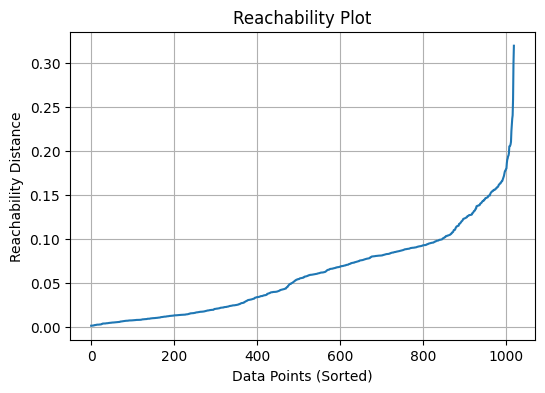

In [ ]:
from gower import gower_matrix
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Compute distances to nearest neighbors
k = round(math.log(len(filtered_data)))
nbrs = NearestNeighbors(n_neighbors=k, metric='precomputed').fit(distance_matrix)
distances, _ = nbrs.kneighbors(distance_matrix)

# Compute reachability distances
reachability_distances = np.mean(distances[:, 1:], axis=1)

# Sort reachability distances in ascending order
sorted_distances = np.sort(reachability_distances)

# Plot reachability distances
plt.figure(figsize=(6, 4))
plt.plot(sorted_distances)
plt.title('Reachability Plot')
plt.xlabel('Data Points (Sorted)')
plt.ylabel('Reachability Distance')
plt.grid(True)
plt.show()


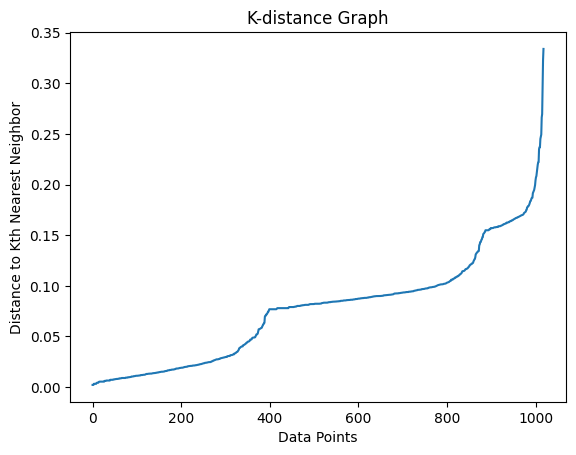

In [ ]:
# Compute distances to K-nearest neighbors
k = round(math.log(len(filtered_data))) # Choose the value of K
nbrs = NearestNeighbors(n_neighbors=k, metric='precomputed').fit(distance_matrix)
distances, _ = nbrs.kneighbors(distance_matrix)

# Sort distances
sorted_distances = np.sort(distances[:, -1])

# Plot K-distance graph
plt.plot(range(len(filtered_data)), sorted_distances)
plt.xlabel('Data Points')
plt.ylabel('Distance to Kth Nearest Neighbor')
plt.title('K-distance Graph')
plt.show()


In [ ]:
def custom_smote_dbscan(X_train, cat_features, pu_ix, nu_ix, group_column_train, total_ratio):
    """
    X_train is the training dataset preprocessed, subgroup_column_train is a column containing the subgroup of each
    instance in X_train
    """
    cat_attr_ix = [i for i, value in enumerate(cat_features) if value]

    X2_df = X_train[group_column_train == pu_ix]
    X2 = X2_df.values
    X3_df = X_train[group_column_train == nu_ix]
    X3 = X3_df.values

    PU = len(X2)
    NU = len(X3)

    # Determine the oversampling target based on a given total_ratio
    if (PU / NU) > total_ratio:
        oversampling_target = (PU / total_ratio) - NU
        os_df = X3_df
        os_ix = nu_ix
    elif (PU / NU) == total_ratio:
        print("The ratio of PU to NU is within the acceptable range of total_ratio.")
        return [], 0, pu_ix
    else:
        oversampling_target = (total_ratio * NU) - PU
        os_df = X2_df
        os_ix = pu_ix
    os_df = os_df.reset_index(drop=True)

    # Calculate Gower distance matrix
    distance_matrix = gower_matrix(os_df, cat_features=cat_features)

    # group 0 : eps = 0.23
    # group 1 : eps = 0.275
    # group 2 : eps = 0.26
    # group 3 : eps = 0.26
    # group 4 : eps = 0.26
    # group 5 : eps = 0.28
    # group 6 : eps = 0.28
    # group 7 : eps = 0.265
    # DBSCAN parameters per group
    eps = {0: 0.1, 1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0.1, 6: 0.1, 7: 0.1}
    #eps = {0: 0.225, 1: 0.26, 2: 0.22, 3: 0.255, 4: 0.255, 5: 0.275, 6: 0.27, 7: 0.25}
    k = round(math.log(len(os_df)))
    dbscan = DBSCAN(eps=eps[os_ix], min_samples=k, metric='precomputed')
    clusters = dbscan.fit_predict(distance_matrix)

    # Get cluster labels
    labels = dbscan.labels_

    # Get core samples
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[dbscan.core_sample_indices_] = True

    # Identify core, border, and noise points
    core_points = os_df[core_samples_mask]
    border_points = os_df[~core_samples_mask & (labels != -1)]
    noise_points = os_df[labels == -1]

    if len(border_points) == 0:
        border_points = core_points

    # Initialize synthetic samples list
    synthetic_samples = []

    border_indices = border_points.index.tolist()
    random.shuffle(border_indices)
    current_index = 0

    while len(synthetic_samples) < oversampling_target:
        idx_A = border_indices[current_index % len(border_indices)]
        #idx_A = core_indices[current_index % len(core_indices)]
        #print(idx_A, 'indice A')
        current_index += 1
        point_A = os_df.loc[idx_A]

        # Ensure point B is not a noise point
        distances_to_A = distance_matrix[idx_A]
        neighbors = np.argsort(distances_to_A)[1:k+1]  # Exclude the point itself
        valid_neighbors = [idx for idx in neighbors if labels[idx] != -1]  # Exclude noise points

        if not valid_neighbors:
            continue  # Skip if no valid neighbors are found

        idx_B = np.random.choice(valid_neighbors)
        point_B = os_df.loc[idx_B]

        synthetic_point = {}
        for i, col in enumerate(os_df.columns):
            if cat_features[i]:
                neighbor_values = os_df.iloc[valid_neighbors][col].tolist()
                synthetic_point[col] = max(set(neighbor_values), key=neighbor_values.count)
            else:
                alpha = np.random.rand()
                synthetic_point[col] = point_A[col] + alpha * (point_B[col] - point_A[col])

        synthetic_samples.append(synthetic_point)

    return pd.DataFrame(synthetic_samples), len(synthetic_samples), os_ix


In [ ]:
def oversample_groups(X_train, cat_features, custom_smote, group_column_train, total_ratio, reverse_group_mapping):
    """
    Function to oversample multiple groups automatically based on group labels.

    Parameters:
    - X_train: Preprocessed training dataset.
    - cat_features: List indicating categorical features.
    - custom_smote: Custom SMOTE function to be used.
    - group_column_train: Column containing the group label for each instance.
    - total_ratio: Desired ratio of positive to negative labels.
    - reverse_group_mapping: Mapping of groups to sensitive attributes and labels.

    Returns:
    - synthetic_samples_matrix: Matrix containing all generated synthetic samples.
    - synthetic_samples_group: Array of group labels for the synthetic samples.
    """

    synthetic_samples = []
    synthetic_samples_group = []

    groups = sorted(group_column_train.unique())
    paired_groups = [(groups[i], groups[i+1]) for i in range(0, len(groups), 2)]

    for group1, group2 in paired_groups:
        ########## Determine pu_ix and nu_ix using reverse_group_mapping ##########
        if reverse_group_mapping[group1][2] == 1:
            pu_ix = group1
            nu_ix = group2
        else:
            pu_ix = group2
            nu_ix = group1
        ##########################################################################

        group_df_pu = X_train[group_column_train == pu_ix]
        group_df_nu = X_train[group_column_train == nu_ix]
        positive_count = group_df_pu[group_df_pu[label] == 1].shape[0]
        negative_count = group_df_nu[group_df_nu[label] == 0].shape[0]

        if positive_count == 0 or negative_count == 0:
            continue

        current_ratio = positive_count / negative_count

        if current_ratio == total_ratio:
            continue  # Skip the most privileged group

        synthetic_points, synthetic_count, os_ix = custom_smote(X_train, cat_features, pu_ix, nu_ix, group_column_train, total_ratio=total_ratio)
        pu_column = np.full((len(synthetic_points), 1), os_ix)
        synthetic_samples.append(synthetic_points)
        synthetic_samples_group.append(pu_column)
        print(f"Oversampling for group pair ({pu_ix}, {nu_ix}): Added {synthetic_count} synthetic samples in {os_ix}.")

    synthetic_samples_matrix = pd.concat(synthetic_samples, ignore_index=True)
    synthetic_samples_group = np.concatenate(synthetic_samples_group)

    return synthetic_samples_matrix, synthetic_samples_group


In [ ]:
synthetic_samples_matrix_dbscan, synthetic_samples_group_dbscan = oversample_groups(X_train, cat_features, custom_smote_dbscan, subgroup_column_train, total_ratio, reverse_group_mapping)

# Concatenate the original dataset with the synthetic samples
X_train_resampled_dbscan = pd.concat([X_train, pd.DataFrame(synthetic_samples_matrix_dbscan, columns=X_train.columns)], ignore_index=True)
#subgroup_column_resampled_tax = pd.concat([X_train[group_column_train], pd.Series(synthetic_samples_group_tax.flatten())], ignore_index=True)


Oversampling for group pair (3, 2): Added 2478 synthetic samples in 3.
Oversampling for group pair (5, 4): Added 297 synthetic samples in 5.
Oversampling for group pair (7, 6): Added 569 synthetic samples in 7.




---



---



---
CLASSIFICATION


In [ ]:
def evaluate_model_performance(X_train, X_test, protected_attributes, label_name, groups, model, weights=None):
    favorable_label = 1.0
    unfavorable_label = 0.0
    X_train[label_name] = X_train[label_name].astype(float)
    X_test[label_name] = X_test[label_name].astype(float)
    # If weights is not provided, create an array of ones with the same length as X_train
    if weights is None:
        weights = np.ones(len(X_train))

    # Create BinaryLabelDatasets
    binary_ds_train = BinaryLabelDataset(df=X_train, label_names=[label_name],
                                         protected_attribute_names=protected_attributes,
                                         favorable_label=favorable_label, unfavorable_label=unfavorable_label)
    binary_ds_test = BinaryLabelDataset(df=X_test, label_names=[label_name],
                                        protected_attribute_names=protected_attributes,
                                        favorable_label=favorable_label, unfavorable_label=unfavorable_label)
    if model == 'Logistic Regression':
        classifier = LogisticRegression(max_iter = 300)
    elif model == 'Random Forest':
        classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    elif model == 'Gradient Boosting':
        classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
    else:
        raise ValueError('Choose one classification algorithm between Logistic Regression, Random Forest, Gradient Boosting')

    classifier.fit(X_train.drop(columns=[label_name]), X_train[label_name], sample_weight=weights)
    predicted_labels = classifier.predict(X_test.drop(columns=[label_name]))

    X_test_with_predictions = pd.concat([X_test.drop(columns=[label_name]), pd.Series(predicted_labels, name=label_name, index=X_test.index)], axis=1)

    binary_ds_test_pred = BinaryLabelDataset(df=X_test_with_predictions, label_names=[label_name],
                                             protected_attribute_names=protected_attributes,
                                             favorable_label=favorable_label, unfavorable_label=unfavorable_label)

    all_results = {}
    for (group1, group2) in itertools.combinations(groups, 2):
        print(group1, group2, 'gruppi')
        pair_key = f"{group1['name']} vs {group2['name']}"
        all_results[pair_key] = evaluate(
            binary_ds_test, binary_ds_test_pred,
            [group1['attributes']], [group2['attributes']])
        #print([group1['attributes']], [group2['attributes']])


    return all_results, predicted_labels

In [ ]:
def evaluate(test_data, pred, priv_group, unpriv_group):
    cm = ClassificationMetric(test_data, pred,
                              unprivileged_groups=unpriv_group,
                              privileged_groups=priv_group)
    dm = BinaryLabelDatasetMetric(pred,
                                  unprivileged_groups=unpriv_group,
                                  privileged_groups=priv_group)

    measure_scores = {
        'Balanced Accuracy': balanced_accuracy_score(test_data.labels, pred.labels),
        'Accuracy': cm.accuracy(),
        'F1 Score': f1_score(test_data.labels.ravel(), pred.labels.ravel()),  # Ensure labels are flat
        'Disparate Impact Ratio': dm.disparate_impact(),
        #'Demographic Parity Difference': cm.statistical_parity_difference(),
        #'Predictive Parity Difference': cm.positive_predictive_value(privileged=True) - cm.positive_predictive_value(privileged=False),
        'Average Odds Difference': cm.average_odds_difference(),
        'Equal Opportunity Difference': cm.equal_opportunity_difference(),
        #'Equalized Odds Difference': cm.average_abs_odds_difference(),
        'Consistency': dm.consistency(),
        #'TPR Difference': cm.true_positive_rate_difference(),
        #'FPR Difference': cm.false_positive_rate_difference(),
        #'TNR Difference': cm.true_negative_rate(privileged=True) - cm.true_negative_rate(privileged=False),
        #'FNR Difference': cm.false_negative_rate_difference(),
    }

    return measure_scores

In [ ]:
def compute_metrics(df, actual_labels, predicted_labels):
    """Compute fairness and performance metrics."""
    cm = confusion_matrix(actual_labels, predicted_labels)
    TN, FP, FN, TP = cm.ravel()
    metrics = {
        'Accuracy': accuracy_score(actual_labels, predicted_labels),
        'Precision': precision_score(actual_labels, predicted_labels),
        'Recall': recall_score(actual_labels, predicted_labels),
        'F1 Score': f1_score(actual_labels, predicted_labels),
        'TPR': TP / (TP + FN),
        'FPR': FP / (FP + TN),
        'TNR': TN / (TN + FP),
        'FNR': FN / (FN + TP),
        'TP': TP,
        'FP': FP,
        'TN': TN,
        'FN': FN
    }

    return metrics

In [ ]:
##################################################################################
results_orig, pred_labels_orig = evaluate_model_performance(X_train, X_test, sensitive_attributes, label,
                                                            groups, model=model)
#model = 'Random Forest'
#model = 'Gradient Boosting'

# Initialize a list to hold DataFrames
data_frames = []

# Populate the list with DataFrames, each having a unique row index
for key, values in results_orig.items():
    df_part = pd.DataFrame([values], index=[key])
    data_frames.append(df_part)

# Concatenate all DataFrames into a single DataFrame
results_orig_df = pd.concat(data_frames)
results_orig_df.index.name = 'Comparison'

# Print the results DataFrame
#print(results_orig_df)

{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi


In [ ]:
##################################################################################
results_dbscan, pred_labels_dbscan = evaluate_model_performance(X_train_resampled_dbscan, X_test, sensitive_attributes, label,
                                                            groups, model=model)

# Initialize a list to hold DataFrames
data_frames = []

# Populate the list with DataFrames, each having a unique row index
for key, values in results_dbscan.items():
    df_part = pd.DataFrame([values], index=[key])
    data_frames.append(df_part)

# Concatenate all DataFrames into a single DataFrame
results_dbscan_df = pd.concat(data_frames)
results_dbscan_df.index.name = 'Comparison'

# Print the results DataFrame
print(results_dbscan_df)

{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
                              Balanced Accuracy  Accuracy  F1 Score  \
Comparison                                                            
White Male vs Black Male               0.782487  0.852628  0.684741   
White Male vs



---



---



---

OTHER MITIGATION ALGORITHMS - FAIR-SMOTE, REWEIGHING, GERRYFAIR, REMEDY



---

FAIR-SMOTE

In [ ]:
!git clone https://github.com/joymallyac/Fair-SMOTE.git

fatal: destination path 'Fair-SMOTE' already exists and is not an empty directory.


In [ ]:
import sys
# Define the new list of directories
new_path = ['/content/Fair-SMOTE']  # Adjust the path as needed

# Replace sys.path with the new list
sys.path = new_path
print(sys.path)

from Generate_Samples import generate_samples
from Measure import measure_final_score, calculate_recall, calculate_far, calculate_precision, calculate_accuracy
from SMOTE import smote
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names, but NearestNeighbors was fitted with feature names")


['/content/Fair-SMOTE']


In [ ]:
def oversample_fair_smote(X_train, sensitive_attributes, label):
    # Extracting group counts
    zero_zero_zero = len(X_train[(X_train[label] == 0) & (X_train[sensitive_attributes[0]] == 0)
                                & (X_train[sensitive_attributes[1]] == 0)])
    zero_zero_one = len(X_train[(X_train[label] == 0) & (X_train[sensitive_attributes[0]] == 0)
                                & (X_train[sensitive_attributes[1]] == 1)])
    zero_one_zero = len(X_train[(X_train[label] == 0) & (X_train[sensitive_attributes[0]] == 1)
                                & (X_train[sensitive_attributes[1]] == 0)])
    zero_one_one = len(X_train[(X_train[label] == 0) & (X_train[sensitive_attributes[0]] == 1)
                                & (X_train[sensitive_attributes[1]] == 1)])
    one_zero_zero = len(X_train[(X_train[label] == 1) & (X_train[sensitive_attributes[0]] == 0)
                                & (X_train[sensitive_attributes[1]] == 0)])
    one_zero_one = len(X_train[(X_train[label] == 1) & (X_train[sensitive_attributes[0]] == 0)
                                & (X_train[sensitive_attributes[1]] == 1)])
    one_one_zero = len(X_train[(X_train[label] == 1) & (X_train[sensitive_attributes[0]] == 1)
                                & (X_train[sensitive_attributes[1]] == 0)])
    one_one_one = len(X_train[(X_train[label] == 1) & (X_train[sensitive_attributes[0]] == 1)
                                & (X_train[sensitive_attributes[1]] == 1)])

    # Finding maximum
    maximum = max(zero_zero_zero, zero_zero_one, zero_one_zero, zero_one_one, one_zero_zero, one_zero_one, one_one_zero, one_one_one)
    print(f"Maximum count: {maximum}")

    # Printing which group has maximum count
    if maximum == zero_zero_zero:
        print("zero_zero_zero is maximum")
    elif maximum == zero_zero_one:
        print("zero_zero_one is maximum")
    elif maximum == zero_one_zero:
        print("zero_one_zero is maximum")
    elif maximum == zero_one_one:
        print("zero_one_one is maximum")
    elif maximum == one_zero_zero:
        print("one_zero_zero is maximum")
    elif maximum == one_zero_one:
        print("one_zero_one is maximum")
    elif maximum == one_one_zero:
        print("one_one_zero is maximum")
    elif maximum == one_one_one:
        print("one_one_one is maximum")

    # Calculating number of samples to be increased for each group
    zero_zero_zero_to_be_increased = maximum - zero_zero_zero
    zero_zero_one_to_be_increased = maximum - zero_zero_one
    zero_one_zero_to_be_increased = maximum - zero_one_zero
    zero_one_one_to_be_increased = maximum - zero_one_one
    one_zero_zero_to_be_increased = maximum - one_zero_zero
    one_zero_one_to_be_increased = maximum - one_zero_one
    one_one_zero_to_be_increased = maximum - one_one_zero
    one_one_one_to_be_increased = maximum - one_one_one

    print(f"Counts to be increased for each group:")
    print(f"zero_zero_zero: {zero_zero_zero_to_be_increased}")
    print(f"zero_zero_one: {zero_zero_one_to_be_increased}")
    print(f"zero_one_zero: {zero_one_zero_to_be_increased}")
    print(f"zero_one_one: {zero_one_one_to_be_increased}")
    print(f"one_zero_zero: {one_zero_zero_to_be_increased}")
    print(f"one_zero_one: {one_zero_one_to_be_increased}")
    print(f"one_one_zero: {one_one_zero_to_be_increased}")
    print(f"one_one_one: {one_one_one_to_be_increased}")

    df_zero_zero_zero = X_train[(X_train[label] == 0) & (X_train[sensitive_attributes[0]] == 0)
                                & (X_train[sensitive_attributes[1]] == 0)].copy()
    df_zero_zero_one = X_train[(X_train[label] == 0) & (X_train[sensitive_attributes[0]] == 0)
                                & (X_train[sensitive_attributes[1]] == 1)].copy()
    df_zero_one_zero = X_train[(X_train[label] == 0) & (X_train[sensitive_attributes[0]] == 1)
                                & (X_train[sensitive_attributes[1]] == 0)].copy()
    df_zero_one_one = X_train[(X_train[label] == 0) & (X_train[sensitive_attributes[0]] == 1)
                                & (X_train[sensitive_attributes[1]] == 1)].copy()
    df_one_zero_zero = X_train[(X_train[label] == 1) & (X_train[sensitive_attributes[0]] == 0)
                                & (X_train[sensitive_attributes[1]] == 0)].copy()
    df_one_zero_one = X_train[(X_train[label] == 1) & (X_train[sensitive_attributes[0]] == 0)
                                & (X_train[sensitive_attributes[1]] == 1)].copy()
    df_one_one_zero = X_train[(X_train[label] == 1) & (X_train[sensitive_attributes[0]] == 1)
                                & (X_train[sensitive_attributes[1]] == 0)].copy()
    df_one_one_one = X_train[(X_train[label] == 1) & (X_train[sensitive_attributes[0]] == 1)
                                & (X_train[sensitive_attributes[1]] == 1)].copy()


    df_zero_zero_zero.loc[:, sensitive_attributes[0]] = df_zero_zero_zero[sensitive_attributes[0]].astype(str)
    df_zero_zero_zero.loc[:, sensitive_attributes[1]] = df_zero_zero_zero[sensitive_attributes[1]].astype(str)

    df_zero_zero_one.loc[:, sensitive_attributes[0]] = df_zero_zero_one[sensitive_attributes[0]].astype(str)
    df_zero_zero_one.loc[:, sensitive_attributes[1]] = df_zero_zero_one[sensitive_attributes[1]].astype(str)

    df_zero_one_zero.loc[:, sensitive_attributes[0]] = df_zero_one_zero[sensitive_attributes[0]].astype(str)
    df_zero_one_zero.loc[:, sensitive_attributes[1]] = df_zero_one_zero[sensitive_attributes[1]].astype(str)

    df_zero_one_one.loc[:, sensitive_attributes[0]] = df_zero_one_one[sensitive_attributes[0]].astype(str)
    df_zero_one_one.loc[:, sensitive_attributes[1]] = df_zero_one_one[sensitive_attributes[1]].astype(str)

    df_one_zero_zero.loc[:, sensitive_attributes[0]] = df_one_zero_zero[sensitive_attributes[0]].astype(str)
    df_one_zero_zero.loc[:, sensitive_attributes[1]] = df_one_zero_zero[sensitive_attributes[1]].astype(str)

    df_one_zero_one.loc[:, sensitive_attributes[0]] = df_one_zero_one[sensitive_attributes[0]].astype(str)
    df_one_zero_one.loc[:, sensitive_attributes[1]] = df_one_zero_one[sensitive_attributes[1]].astype(str)

    df_one_one_zero.loc[:, sensitive_attributes[0]] = df_one_one_zero[sensitive_attributes[0]].astype(str)
    df_one_one_zero.loc[:, sensitive_attributes[1]] = df_one_one_zero[sensitive_attributes[1]].astype(str)

    df_one_one_one.loc[:, sensitive_attributes[0]] = df_one_one_one[sensitive_attributes[0]].astype(str)
    df_one_one_one.loc[:, sensitive_attributes[1]] = df_one_one_one[sensitive_attributes[1]].astype(str)

    # Generating samples for each group
    df_zero_zero_zero = generate_samples(zero_zero_zero_to_be_increased, df_zero_zero_zero, 'Germann')
    df_zero_zero_one = generate_samples(zero_zero_one_to_be_increased, df_zero_zero_one, 'Germann')
    df_zero_one_zero = generate_samples(zero_one_zero_to_be_increased, df_zero_one_zero, 'Germann')
    df_zero_one_one = generate_samples(zero_one_one_to_be_increased, df_zero_one_one, 'Germann')
    df_one_zero_zero = generate_samples(one_zero_zero_to_be_increased, df_one_zero_zero, 'Germann')
    df_one_zero_one = generate_samples(one_zero_one_to_be_increased, df_one_zero_one, 'Germann')
    df_one_one_zero = generate_samples(one_one_zero_to_be_increased, df_one_one_zero, 'Germann')
    df_one_one_one = generate_samples(one_one_one_to_be_increased, df_one_one_one, 'Germann')

    # Concatenating dataframes
    X_train_resampled_fair_smote = pd.concat([df_zero_zero_zero, df_zero_zero_one, df_zero_one_zero, df_zero_one_one,
                                              df_one_zero_zero, df_one_zero_one, df_one_one_zero, df_one_one_one])
    X_train_resampled_fair_smote.columns = X_train.columns

    return X_train_resampled_fair_smote


In [ ]:
###################################################################################
X_train_resampled_fair_smote = oversample_fair_smote(X_train, sensitive_attributes, label)
# Evaluate model performance
results_fair_smote, pred_labels_fair_smote = evaluate_model_performance(X_train_resampled_fair_smote, X_test, sensitive_attributes, label,
                                                            groups, model=model)
# Initialize a list to hold DataFrames
data_frames = []

# Populate the list with DataFrames, each having a unique row index
for key, values in results_fair_smote.items():
    df_part = pd.DataFrame([values], index=[key])
    data_frames.append(df_part)

# Concatenate all DataFrames into a single DataFrame
results_fair_smote_df = pd.concat(data_frames)
results_fair_smote_df.index.name = 'Comparison'

# Print the results DataFrame
print(results_fair_smote_df)

Maximum count: 12787
zero_one_one is maximum
Counts to be increased for each group:
zero_zero_zero: 11416
zero_zero_one: 11572
zero_one_zero: 5488
zero_one_one: 0
one_zero_zero: 12699
one_zero_one: 12501
one_one_zero: 11768
one_one_one: 6661
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 's



---

REWEIGHTING

In [ ]:
!git clone https://github.com/IBM/AIF360.git

fatal: destination path 'AIF360' already exists and is not an empty directory.


In [ ]:
new_path = ['/content']
sys.path = new_path
from reweighing_cust import Reweighing

In [ ]:
class CustomDataset:
    def __init__(self, data, sensitive_attributes, label):
        self.data = data
        self.protected_attribute_names = sensitive_attributes
        self.protected_attributes = np.column_stack([data[sensitive_attributes[0]], data[sensitive_attributes[1]]])
        self.labels = data[label].astype(float).values.reshape(-1, 1)
        self.favorable_label = 1.0
        self.unfavorable_label = 0.0
        self.instance_weights = np.ones(len(data))
        self.privileged_protected_attributes = [np.array([1.]), np.array([1.])]
        self.unprivileged_protected_attributes = [np.array([0.]), np.array([0.])]
        self.feature_names = data.columns[data.columns != label].tolist()

custom_data = CustomDataset(X_train, sensitive_attributes, label)

In [ ]:
privileged_groups = [{sensitive_attributes[0]: 1, sensitive_attributes[1]: 1}]
unprivileged_groups = [{sensitive_attributes[0]: 0, sensitive_attributes[1]: 0}]
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)

RW.fit(custom_data)
dataset_transf_train = RW.transform(custom_data)

In [ ]:
results_reweighing, pred_labels_reweighing = evaluate_model_performance(X_train, X_test, sensitive_attributes, label,
                                                                        groups, model = model,
                                                                        weights=custom_data.instance_weights)
# Initialize a list to hold DataFrames
data_frames = []

# Populate the list with DataFrames, each having a unique row index
for key, values in results_reweighing.items():
    df_part = pd.DataFrame([values], index=[key])
    data_frames.append(df_part)

# Concatenate all DataFrames into a single DataFrame
results_reweighing_df = pd.concat(data_frames)
results_reweighing_df.index.name = 'Comparison'

# Print the results DataFrame
print(results_reweighing_df)

{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
                              Balanced Accuracy  Accuracy  F1 Score  \
Comparison                                                            
White Male vs Black Male               0.752476   0.85881  0.655997   
White Male vs



---

GERRY FAIR

In [ ]:
# import copy
# from aif360.algorithms.inprocessing.gerryfair import heatmap
# from aif360.algorithms.inprocessing.gerryfair.clean import array_to_tuple
# from aif360.algorithms.inprocessing.gerryfair.learner import Learner
# from aif360.algorithms.inprocessing.gerryfair.auditor import *
# from aif360.algorithms.inprocessing.gerryfair.classifier_history import ClassifierHistory
# from aif360.algorithms import Transformer

In [ ]:
# classifier = GerryFairClassifier(C=10, printflag=True, heatmapflag=False, max_iters=50, gamma=0.01, fairness_def='FP')
# # NOTE : fairness definition = FP, so it decreases the values of FPR. FN works bad, SP doesn't work
# # even though FPR is small, SP is not that close to 1

# binary_ds_train = BinaryLabelDataset(df=X_train, label_names=[label],
#                                     protected_attribute_names=sensitive_attributes,
#                                     favorable_label=1.0, unfavorable_label=0.0)
# binary_ds_test =  BinaryLabelDataset(df=X_test, label_names=[label],
#                                     protected_attribute_names=sensitive_attributes,
#                                     favorable_label=1.0, unfavorable_label=0.0)

# # Fit the classifier on the dataset
# classifier.fit(binary_ds_train, early_termination=True)

# # Make predictions on the test set
# binary_ds_test_pred = classifier.predict(binary_ds_test)

# all_results = {}
# for (group1, group2) in itertools.combinations(groups, 2):
#     pair_key = f"{group1['name']} vs {group2['name']}"
#     all_results[pair_key] = evaluate(
#         binary_ds_test, binary_ds_test_pred,
#         [group1['attributes']], [group2['attributes']]
#     )

# # Evaluate model performance using evaluate method
# results_gerryF = all_results

In [ ]:
# # Initialize a list to hold DataFrames
# data_frames = []

# # Populate the list with DataFrames, each having a unique row index
# for key, values in results_gerryF.items():
#     df_part = pd.DataFrame([values], index=[key])
#     data_frames.append(df_part)

# # Concatenate all DataFrames into a single DataFrame
# results_gerryF_df = pd.concat(data_frames)
# results_gerryF_df.index.name = 'Comparison'

# # Print the results DataFrame
# print(results_gerryF_df)



---

REMEDY

In [ ]:
import sys
sys.path.append('/content')  # Add the directory containing remedy_cust.py to the Python path
from remedy_cust import *

In [ ]:
columns_all = X_train.drop(columns=[label])
label_y = label
columns_protected = sensitive_attributes

In [ ]:
#names = ["Output of get_temp function, all of the attributes for given group"]
#temp2 = ["Output of get_temp function, sum count by group"]
temp2, names = get_temp(X_train, columns_protected, label_y)
print(temp2, names)
#temp2 counts the number of instances for each combination of sensitive attr and label (like my group count)
#names is the list of sensit attr
unfair_group, unfair_names, skew_candidates, unfair_dict = get_unfair_group(columns_protected, [])
#all empty beside skew candidates that is the list of sensitive attr
print(unfair_group, unfair_names, skew_candidates, unfair_dict)
#all_names is a dict that has 0:[], 1:sens attr1, 2:sens attr2, 3:sens attr1, sens attr2. So for each key (number) it
#associates all possible combinations of sens attr
all_names = candidate_groups(skew_candidates, unfair_dict, columns_protected, unfair_names)
#name values is a dict with sens attrib: possible values
names_values = name_val_dict(X_train, names)

all_names_lst = list(all_names.keys())[1:] # CHANGED HERE
all_names_lst.reverse()
#all_names_lst is a list of the keys of the dict all_names, so numbers [3,2,1]
all_names_lst

['race', 'sex', 'income']
   race  sex  income    cnt
0     0    0     0.0   1371
1     0    0     1.0     88
2     0    1     0.0   1215
3     0    1     1.0    286
4     1    0     0.0   7299
5     1    0     1.0   1019
6     1    1     0.0  12787
7     1    1     1.0   6126 ['race', 'sex']
[] [] ['race', 'sex'] {}


[3, 2, 1]

In [ ]:
#get all of the candidate groups possible with the combos and names
filter_count = 30
#copy of the dataset
new_train_data = copy.deepcopy(X_train)
print(new_train_data.shape[0])

#iterate over all the names to get the temp2 df for each name
for a in all_names_lst:
  print("?????/////")
  print(a)
  #temp2 counts the number of instances for each combination of sensitive attr and label (like my group count)
  #names is the list of sensit attr
  temp2, names = get_temp(new_train_data, all_names[a], label_y)
  print(temp2, '\n', names, 'temp2,names \n')
  #temp is a df with the entire columns, where the columns are in the first iteration all sens attr and the label
  # in the second iteration are one sens attrib and the label
  # temp_g counts the instances considering only the sens attrib (first iteration both sens attr, then only one at the time)
  temp, temp_g = get_temp_g(new_train_data, names, label_y)
  print(temp,'\n', temp_g, 'temp,temp_g \n')
  temp_g = temp_g[temp_g['cnt'] > filter_count]
  #lst_of_counts is a list of df, the first df have first sens attr and the credit + count, the second is second sens attr
  #and the credit + count
  lst_of_counts = compute_lst_of_counts(temp, names, label_y)
  print(lst_of_counts, 'listof counts \n')

  need_pos, need_neg = compute_problematic_opt(temp2, temp_g, names, label_y, lst_of_counts)
  print("The sets of need pos and neg are")
  print(need_pos)
  print(need_neg)
  new_train_data['skewed'] = 0
  new_train_data["diff"] = 0
  print("started duplication")
  new_train_data = naive_duplicate(new_train_data, temp2, names, need_pos, need_neg, label_y)
  print(new_train_data.shape[0])
  print("label y ", new_train_data[label_y].value_counts())
#new_train_x = pd.DataFrame(new_train_data, columns = columns_all)
new_train_label = pd.DataFrame(new_train_data, columns = [label_y])
new_train_label = new_train_label[label_y]
new_train_label = new_train_label.astype('int')

30191
?????/////
3
['race', 'sex', 'income']
   race  sex  income    cnt
0     0    0     0.0   1371
1     0    0     1.0     88
2     0    1     0.0   1215
3     0    1     1.0    286
4     1    0     0.0   7299
5     1    0     1.0   1019
6     1    1     0.0  12787
7     1    1     1.0   6126 
 ['race', 'sex'] temp2,names 

      race sex  income  cnt
0        1   1     0.0    0
1        1   1     0.0    0
2        1   1     1.0    0
3        1   1     0.0    0
4        0   0     0.0    0
...    ...  ..     ...  ...
30186    1   1     0.0    0
30187    1   1     0.0    0
30188    1   1     1.0    0
30189    1   1     0.0    0
30190    1   0     0.0    0

[30191 rows x 4 columns] 
    race  sex    cnt
0     0    0   1459
1     0    1   1501
2     1    0   8318
3     1    1  18913 temp,temp_g 

[sex  income
0    0.0        8670
     1.0        1107
1    0.0       14002
     1.0        6412
Name: cnt, dtype: int64, race  income
0     0.0        2586
      1.0         374
1     0.0     

In [ ]:
X_train_resampled_remedy = new_train_data.drop(columns= ['skewed', 'diff'])
# Evaluate model performance
results_remedy, pred_labels_remedy = evaluate_model_performance(X_train_resampled_remedy, X_test, sensitive_attributes,
                                                                label, groups, model= model)

{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi


In [ ]:
# Initialize a list to hold DataFrames
data_frames = []

# Populate the list with DataFrames, each having a unique row index
for key, values in results_remedy.items():
    df_part = pd.DataFrame([values], index=[key])
    data_frames.append(df_part)

# Concatenate all DataFrames into a single DataFrame
results_remedy_df = pd.concat(data_frames)
results_remedy_df.index.name = 'Comparison'

# Print the results DataFrame
print(results_remedy_df)

                              Balanced Accuracy  Accuracy  F1 Score  \
Comparison                                                            
White Male vs Black Male               0.678335  0.834235  0.524917   
White Male vs White Female             0.678335  0.834235  0.524917   
White Male vs Black Female             0.678335  0.834235  0.524917   
Black Male vs White Female             0.678335  0.834235  0.524917   
Black Male vs Black Female             0.678335  0.834235  0.524917   
White Female vs Black Female           0.678335  0.834235  0.524917   

                              Disparate Impact Ratio  Average Odds Difference  \
Comparison                                                                      
White Male vs Black Male                    0.916447                 0.054492   
White Male vs White Female                  0.738817                 0.121021   
White Male vs Black Female                  0.342851                 0.097646   
Black Male vs White Female



---



---



---

COMPARE


In [ ]:
class ModelEvaluator:
    def __init__(self, df, protected_attributes, label_name, privileged, unprivileged, fav, unfav, groups, num_iterations=10, oversampling_methods=None):
        self.df = df
        self.protected_attributes = protected_attributes
        self.label_name = label_name
        self.privileged = privileged
        self.unprivileged = unprivileged
        self.fav = fav
        self.unfav = unfav
        self.groups = groups
        self.num_iterations = num_iterations
        self.oversampling_methods = oversampling_methods if oversampling_methods is not None else ['none']

    def evaluate_model_performance_mean(self):
        results_dict = {method: [] for method in self.oversampling_methods}

        for _ in range(self.num_iterations):
            data_prep = DataPreparation(self.df, self.protected_attributes, self.label_name,
                                        self.privileged, self.unprivileged, self.fav, self.unfav)
            data_prep.prepare()
            data_prep.df = data_prep.df.reset_index(drop=True)
            X_train, X_test = data_prep.X_train, data_prep.X_test
            X_train = X_train.reset_index(drop=True)
            cat_features = data_prep.cat_features
            numerical_features = data_prep.numerical_features
            reverse_group_mapping = data_prep.create_group_column()
            group_counts_train = X_train['Group'].value_counts().sort_index()
            subgroup_column_train = X_train['Group']
            subgroup_column_test = X_test['Group']
            X_train = X_train.drop(columns=['Group'])
            X_test = X_test.drop(columns=['Group'])

            num_privileged_ones = X_train[(X_train[self.protected_attributes[0]] == 1) &
                                          (X_train[self.protected_attributes[1]] == 1) &
                                          (X_train[self.label_name] == 1)].shape[0]
            num_privileged_zeros = X_train[(X_train[self.protected_attributes[0]] == 1) &
                                          (X_train[self.protected_attributes[1]] == 1) &
                                          (X_train[self.label_name] == 0)].shape[0]
            total_ratio = num_privileged_ones / num_privileged_zeros if num_privileged_zeros != 0 else float('inf')

            for method in self.oversampling_methods:
                X_train_method = X_train.copy()
                if method == 'none':
                    results, pred_labels = evaluate_model_performance(X_train_method, X_test, self.protected_attributes, self.label_name,
                                                                      self.groups, model=model)
                elif method == 'custom_smote_km':
                    X_train_no_sens = X_train_method.drop(columns=[self.protected_attributes[0], self.protected_attributes[1], self.label_name])
                    X_reduced = X_train_no_sens

                    kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=300, random_state=42)
                    clusters = kmeans.fit_predict(X_reduced)
                    X_train_method['Cluster_Labels'] = clusters

                    all_synthetic_samples_km = oversample_clusters(X_train_method, 'Cluster_Labels', self.protected_attributes,
                                                                   self.label_name, total_ratio, cat_features)
                    X_train_method = X_train_method.drop(columns=['Cluster_Labels'])
                    X_train_resampled_km = pd.concat([X_train_method, all_synthetic_samples_km], ignore_index=True)
                    results, pred_labels = evaluate_model_performance(X_train_resampled_km, X_test, self.protected_attributes,
                                                                      self.label_name, self.groups, model=model)
                elif method == 'custom_smote_dbscan':
                    synthetic_samples_matrix_dbscan, synthetic_samples_group_dbscan = oversample_groups(X_train_method, cat_features, custom_smote_dbscan, subgroup_column_train, total_ratio, reverse_group_mapping)
                    X_train_resampled_dbscan = pd.concat([X_train_method, pd.DataFrame(synthetic_samples_matrix_dbscan, columns=X_train.columns)], ignore_index=True)
                    results, pred_labels = evaluate_model_performance(X_train_resampled_dbscan, X_test, self.protected_attributes,
                                                                      self.label_name, self.groups, model=model)
                elif method == 'custom_smote_tax':
                    synthetic_samples_matrix_tax, synthetic_samples_group_tax = oversample_groups(X_train_method, cat_features, custom_smote_tax, subgroup_column_train, total_ratio, reverse_group_mapping)
                    X_train_resampled_tax = pd.concat([X_train_method, pd.DataFrame(synthetic_samples_matrix_tax, columns=X_train.columns)], ignore_index=True)
                    results, pred_labels = evaluate_model_performance(X_train_resampled_tax, X_test, self.protected_attributes,
                                                                      self.label_name, self.groups, model=model)
                elif method == 'Fair-SMOTE':
                    X_train_resampled_fair_smote = oversample_fair_smote(X_train_method, self.protected_attributes, self.label_name)
                    results, pred_labels = evaluate_model_performance(X_train_resampled_fair_smote, X_test, self.protected_attributes,
                                                                      self.label_name, self.groups, model=model)
                elif method == 'Reweighing':
                    custom_data = CustomDataset(X_train_method, self.protected_attributes, self.label_name)
                    privileged_groups = [{self.protected_attributes[0]: 1, self.protected_attributes[1]: 1}]
                    unprivileged_groups = [{self.protected_attributes[0]: 0, self.protected_attributes[1]: 0}]
                    RW = Reweighing(unprivileged_groups=unprivileged_groups,
                                    privileged_groups=privileged_groups)
                    RW.fit(custom_data)
                    dataset_transf_train = RW.transform(custom_data)

                    results, pred_labels = evaluate_model_performance(X_train_method, X_test, self.protected_attributes, self.label_name,
                                                                      self.groups, model=model, weights=custom_data.instance_weights)
                elif method == 'Remedy':
                    columns_all = X_train_method.drop(columns=[self.label_name])
                    label_y = self.label_name
                    columns_protected = self.protected_attributes
                    temp2, names = get_temp(X_train_method, columns_protected, label_y)
                    unfair_group, unfair_names, skew_candidates, unfair_dict = get_unfair_group(columns_protected, [])
                    print(unfair_group, unfair_names, skew_candidates, unfair_dict)
                    all_names = candidate_groups(skew_candidates, unfair_dict, columns_protected, unfair_names)
                    names_values = name_val_dict(X_train_method, names)

                    all_names_lst = list(all_names.keys())[1:]
                    all_names_lst.reverse()
                    filter_count = 30
                    new_train_data = copy.deepcopy(X_train_method)

                    for a in all_names_lst:
                        temp2, names = get_temp(new_train_data, all_names[a], label_y)
                        temp, temp_g = get_temp_g(new_train_data, names, label_y)
                        temp_g = temp_g[temp_g['cnt'] > filter_count]
                        lst_of_counts = compute_lst_of_counts(temp, names, label_y)
                        need_pos, need_neg = compute_problematic_opt(temp2, temp_g, names, label_y, lst_of_counts)
                        new_train_data['skewed'] = 0
                        new_train_data["diff"] = 0
                        new_train_data = naive_duplicate(new_train_data, temp2, names, need_pos, need_neg, label_y)
                    new_train_label = pd.DataFrame(new_train_data, columns=[label_y])
                    new_train_label = new_train_label[label_y]
                    new_train_label = new_train_label.astype('int')

                    X_train_resampled_remedy = new_train_data.drop(columns=['skewed', 'diff'])

                    results, pred_labels = evaluate_model_performance(X_train_resampled_remedy, X_test, self.protected_attributes,
                                                                      self.label_name, self.groups, model=model)

                data_frames = []
                for key, values in results.items():
                    df_part = pd.DataFrame([values], index=[key])
                    data_frames.append(df_part)

                results_df = pd.concat(data_frames)
                results_df.index.name = 'Comparison'
                results_dict[method].append(results_df)

        combined_results = {method: pd.concat(results_dict[method]).groupby(level=0).mean() for method in self.oversampling_methods}
        return combined_results


In [ ]:
evaluators = {
    'ModelEvaluator': ModelEvaluator(df, sensitive_attributes, label, privileged, unprivileged, favorable_label, unfavorable_label, groups, num_iterations=10, oversampling_methods=['none', 'custom_smote_dbscan', 'Fair-SMOTE', 'Reweighing', 'Remedy'])
}

results = {}

# Evaluate all models and store results
for key, evaluator in evaluators.items():
    results[key] = evaluator.evaluate_model_performance_mean()

# Display the results
for method, result in results['ModelEvaluator'].items():
    print(f"Results for {method} method:")
    print(result)

Detected 3316 rows with missing values. Removed them.
The 'income' column has only two unique values.
{'workclass': {'Federal-gov': 0, 'Local-gov': 1, 'Private': 2, 'Self-emp-inc': 3, 'Self-emp-not-inc': 4, 'State-gov': 5, 'Without-pay': 6}, 'education': {'10th': 0, '11th': 1, '12th': 2, '1st-4th': 3, '5th-6th': 4, '7th-8th': 5, '9th': 6, 'Assoc-acdm': 7, 'Assoc-voc': 8, 'Bachelors': 9, 'Doctorate': 10, 'HS-grad': 11, 'Masters': 12, 'Preschool': 13, 'Prof-school': 14, 'Some-college': 15}, 'marital_status': {'Divorced': 0, 'Married-AF-spouse': 1, 'Married-civ-spouse': 2, 'Married-spouse-absent': 3, 'Never-married': 4, 'Separated': 5, 'Widowed': 6}, 'occupation': {'Adm-clerical': 0, 'Armed-Forces': 1, 'Craft-repair': 2, 'Exec-managerial': 3, 'Farming-fishing': 4, 'Handlers-cleaners': 5, 'Machine-op-inspct': 6, 'Other-service': 7, 'Priv-house-serv': 8, 'Prof-specialty': 9, 'Protective-serv': 10, 'Sales': 11, 'Tech-support': 12, 'Transport-moving': 13}, 'relationship': {'Husband': 0, 'Not-

<ipython-input-223-6d4e21d044d2>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Oversampling for group pair (3, 2): Added 2478 synthetic samples in 3.
Oversampling for group pair (5, 4): Added 297 synthetic samples in 5.
Oversampling for group pair (7, 6): Added 569 synthetic samples in 7.
{'name': 'White

<ipython-input-223-6d4e21d044d2>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Oversampling for group pair (3, 2): Added 2478 synthetic samples in 3.
Oversampling for group pair (5, 4): Added 297 synthetic samples in 5.
Oversampling for group pair (7, 6): Added 569 synthetic samples in 7.
{'name': 'White

<ipython-input-223-6d4e21d044d2>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Oversampling for group pair (3, 2): Added 2478 synthetic samples in 3.
Oversampling for group pair (5, 4): Added 297 synthetic samples in 5.
Oversampling for group pair (7, 6): Added 569 synthetic samples in 7.
{'name': 'White

<ipython-input-223-6d4e21d044d2>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)


[(0, (1, 1, 0)), (1, (1, 1, 1)), (2, (1, 0, 0)), (3, (1, 0, 1)), (4, (0, 1, 0)), (5, (0, 1, 1)), (6, (0, 0, 0)), (7, (0, 0, 1))]
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Oversampling for group pair (3, 2): Added 2478 synthetic samples in 3.
Oversampling for group pai

<ipython-input-223-6d4e21d044d2>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)


[(0, (1, 1, 0)), (1, (1, 1, 1)), (2, (1, 0, 0)), (3, (1, 0, 1)), (4, (0, 1, 0)), (5, (0, 1, 1)), (6, (0, 0, 0)), (7, (0, 0, 1))]
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Oversampling for group pair (3, 2): Added 2478 synthetic samples in 3.
Oversampling for group pai

<ipython-input-223-6d4e21d044d2>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Oversampling for group pair (3, 2): Added 2478 synthetic samples in 3.
Oversampling for group pair (5, 4): Added 297 synthetic samples in 5.
Oversampling for group pair (7, 6): Added 569 synthetic samples in 7.
{'name': 'White

<ipython-input-223-6d4e21d044d2>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Oversampling for group pair (3, 2): Added 2478 synthetic samples in 3.
Oversampling for group pair (5, 4): Added 297 synthetic samples in 5.
Oversampling for group pair (7, 6): Added 569 synthetic samples in 7.
{'name': 'White

<ipython-input-223-6d4e21d044d2>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Oversampling for group pair (3, 2): Added 2478 synthetic samples in 3.
Oversampling for group pair (5, 4): Added 297 synthetic samples in 5.
Oversampling for group pair (7, 6): Added 569 synthetic samples in 7.
{'name': 'White

<ipython-input-223-6d4e21d044d2>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Oversampling for group pair (3, 2): Added 2478 synthetic samples in 3.
Oversampling for group pair (5, 4): Added 297 synthetic samples in 5.
Oversampling for group pair (7, 6): Added 569 synthetic samples in 7.
{'name': 'White

<ipython-input-223-6d4e21d044d2>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Group'] = pd.MultiIndex.from_frame(self.df[self.sensitive + [self.label]]).map(group_mapping)


{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'White Male', 'attributes': {'race': 1, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} gruppi
{'name': 'Black Male', 'attributes': {'race': 0, 'sex': 1}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
{'name': 'White Female', 'attributes': {'race': 1, 'sex': 0}} {'name': 'Black Female', 'attributes': {'race': 0, 'sex': 0}} gruppi
Oversampling for group pair (3, 2): Added 2478 synthetic samples in 3.
Oversampling for group pair (5, 4): Added 297 synthetic samples in 5.
Oversampling for group pair (7, 6): Added 569 synthetic samples in 7.
{'name': 'White

In [ ]:
# Print all results in a formatted way
for key, result in results.items():
    print(f"Results for {key}:")
    print(result)
    print("\n" + "-"*40 + "\n")  # Print a separator for better readability

Results for ModelEvaluator:
{'none':                               Balanced Accuracy  Accuracy  F1 Score  \
Comparison                                                            
Black Male vs Black Female              0.78077  0.863323   0.69188   
Black Male vs White Female              0.78077  0.863323   0.69188   
White Female vs Black Female            0.78077  0.863323   0.69188   
White Male vs Black Female              0.78077  0.863323   0.69188   
White Male vs Black Male                0.78077  0.863323   0.69188   
White Male vs White Female              0.78077  0.863323   0.69188   

                              Disparate Impact Ratio  Average Odds Difference  \
Comparison                                                                      
Black Male vs Black Female                  0.280414                -0.067074   
Black Male vs White Female                  0.617163                -0.023378   
White Female vs Black Female                0.458434                -0

In [ ]:

#comparison_key = 'Male Adult vs Female Young'
#comparison_key = 'Caucasian Female vs Black Male'
comparison_key = 'White Male vs Black Female'

# Create an empty list to store the extracted data
data = []

# Iterate over the results dictionary and extract the relevant data
for method, result_dict in results['ModelEvaluator'].items():
    if comparison_key in result_dict.index:
        metrics = result_dict.loc[comparison_key]
        row = {
            'Classifier': model,
            'Technique': method,
            'DI Ratio': metrics['Disparate Impact Ratio'],
            'AEO Diff.': metrics['Average Odds Difference'],
            'Equal Opportunity Difference': metrics['Equal Opportunity Difference'],
            'Consis.': metrics['Consistency'],
            'Acc.': metrics['Accuracy'],
            'Bal. Acc.': metrics['Balanced Accuracy'],
            'F1 Score': metrics['F1 Score']
        }
        data.append(row)

# Convert the extracted data into a DataFrame
df_results = pd.DataFrame(data)

# Print the DataFrame as a formatted table
print(df_results.to_string(index=False))


       Classifier           Technique  DI Ratio  AEO Diff.  Equal Opportunity Difference              Consis.     Acc.  Bal. Acc.  F1 Score
Gradient Boosting                none  0.139943  -0.126623                     -0.178933 [0.9446769706336935] 0.863323   0.780770  0.691880
Gradient Boosting custom_smote_dbscan  0.322113  -0.001267                      0.040668 [0.9368686244204014] 0.852148   0.783527  0.685381
Gradient Boosting          Fair-SMOTE  0.150637  -0.120278                     -0.144350 [0.9429953632148373] 0.849420   0.770912  0.670205
Gradient Boosting          Reweighing  0.324304   0.032216                      0.080256  [0.947550231839258] 0.858076   0.751032  0.653614
Gradient Boosting              Remedy  0.328488   0.063692                      0.124819 [0.9568454404945907] 0.836229   0.682038  0.532679
